In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import itertools
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## The Problem
A Superstore is opening a new pastry section that sells artisinal cakes, doughnuts, cookies and other pastries. How can we target our ad campaigns to attract customers to our new section?

By understanding our customers deeply, we can create targeted ads that increase customer engagement with our products. And one way to do that is to understand their buying behaviours.

In [2]:
# Load the dataset
file_path = "customer_segmentation.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "vishakhdapat/customer-segmentation-clustering",
    file_path,
)

df.info()

/tmp/ipython-input-1123484237.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'customer-segmentation-clustering' dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  M

In [3]:
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
# check for NaN
df[df.isna().any(axis =1)]

# there are only 24 records with no income, so we can delete them
df = df.dropna()
df.shape

(2216, 29)

## Feature Selection
For the clustering step, we'll focus on selecting features that could effectively capture differences among our customers.

At first glance, variables such as *marital status*, *number of children*, *frequency of in-store purchases* and *amount spent in sweet products* appear to be meaningful indicators.
The reasoning is that individuals who are married, single, or have children are likely to exhibit distinct purchasing patterns. Households with kids, for instance, may have different needs compared to those without. In addition, how often a customer visits the store gives us a sense of their level of engagement and buying habits.

In [5]:
# we combine Kidhome and Teenhome to get the total number of children
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']

features = ['Marital_Status', 'TotalChildren', 'NumStorePurchases', 'MntSweetProducts']

df_subset = df[features]

While exploring the data, we notice that the *Marital_Status* column contains eight unique categories. For this analysis, we can simplify it by merging similar groups (e.g., *Married* and *Together*) and removing uncommon or irrelevant entries (such as *Absurd* and *YOLO*), which appear to be outliers.

In [6]:
df_subset.Marital_Status.value_counts()

,count
Marital_Status,
Married,857
Together,573
Single,471
Divorced,232
Widow,76
Alone,3
Absurd,2
YOLO,2


In [7]:
# drop rows with outliers
df_subset = df_subset[~df_subset['Marital_Status'].isin(['Absurd', 'YOLO'])]

# create a mapping for similar features
marital_status_map = { 'Married' : 1,
                      'Together' : 1,
                      'Single'   : 2,
                      'Divorced' : 2,
                      'Widow'    : 2,
                      'Alone'    : 2}

df_subset['Status'] = df_subset.Marital_Status.map(marital_status_map)
df_subset = df_subset.drop(columns = ['Marital_Status'])
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   TotalChildren      2212 non-null   int64
 1   NumStorePurchases  2212 non-null   int64
 2   MntSweetProducts   2212 non-null   int64
 3   Status             2212 non-null   int64
dtypes: int64(4)
memory usage: 86.4 KB


## Feature Scaling

In [8]:
scaler = StandardScaler()

scaled = scaler.fit_transform(df_subset)
df_scaled = pd.DataFrame(scaled, columns = df_subset.columns)

In [9]:
df_scaled.head()

,TotalChildren,NumStorePurchases,MntSweetProducts,Status
0,-1.265658,-0.553411,1.483638,1.352274
1,1.404476,-1.168251,-0.634018,1.352274
2,-1.265658,1.291108,-0.147201,-0.739495
3,0.069409,-0.553411,-0.585336,-0.739495
4,0.069409,0.061428,-0.001155,-0.739495


## K Means
To determine the numebr of clusters *K*, we use the **inertia method**. We will compute the Within-Cluster Sum of Squares (WCSS), plot it and look for the *elbow*, the point where adding more clusters doesn’t significantly improve the fit.

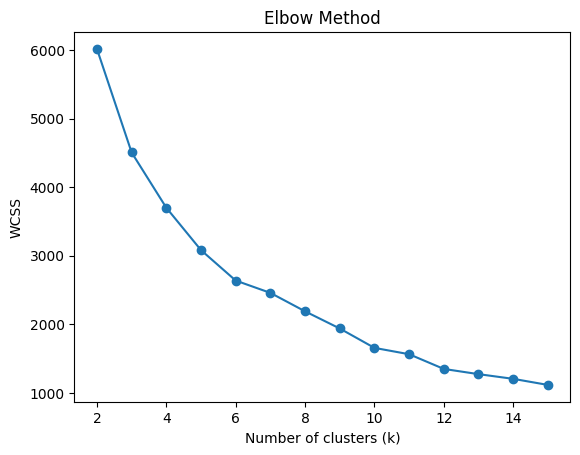

In [10]:
wcss = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 16), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

K = 5 or 6 appears to be a good choice based on the elbow method.
Let's validate this by computing the **silhouette score**, which measures how well each point fits within its cluster compared to others.


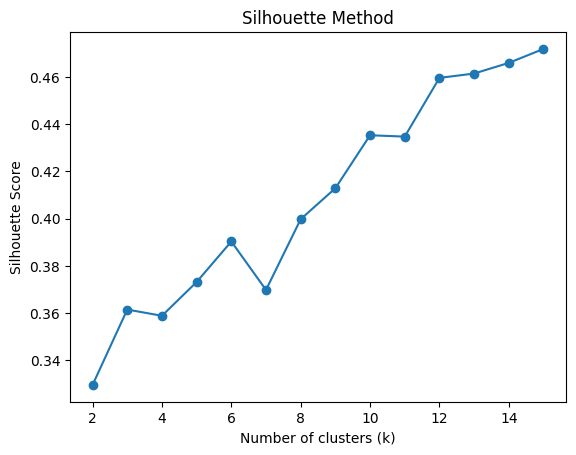

In [11]:
sil = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    sil.append(silhouette_score(df_scaled, labels))

plt.plot(range(2, 16), sil, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [12]:
kmeans = KMeans(n_clusters = 6, n_init = 'auto', random_state = 42)
kmeans.fit(df_scaled)

cluster_df = pd.concat([df_scaled, pd.Series(kmeans.labels_, name = 'cluster_labels')], axis = 1)
cluster_df.head()

,TotalChildren,NumStorePurchases,MntSweetProducts,Status,cluster_labels
0,-1.265658,-0.553411,1.483638,1.352274,4
1,1.404476,-1.168251,-0.634018,1.352274,2
2,-1.265658,1.291108,-0.147201,-0.739495,3
3,0.069409,-0.553411,-0.585336,-0.739495,1
4,0.069409,0.061428,-0.001155,-0.739495,1


## PCA
PCA helps us shrink a dataset with many features down to just 2 or 3 dimensions so we can actually see it. It picks the directions where the data varies the most, letting us spot patterns and clusters more easily. Basically, it makes complex data easier to visualize without losing the important stuff.

In [13]:
# exclude cluster_labels
X = cluster_df.drop('cluster_labels', axis=1)

# we pick 3 PCs for 3d plot
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X)

# 2 PCs for 2d plot
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X)


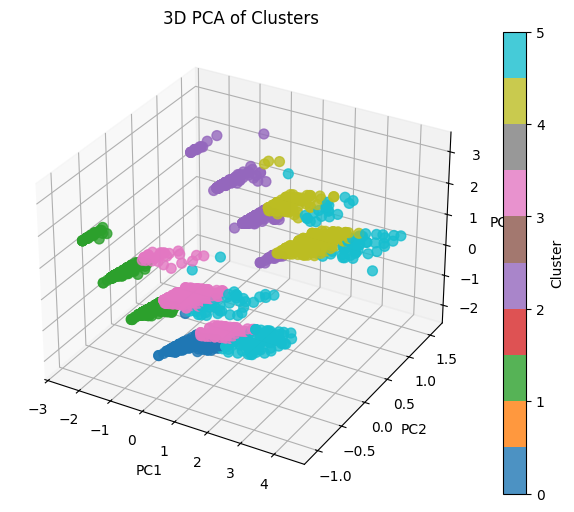

In [14]:
# 3d plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_pca_3d[:,0],
    X_pca_3d[:,1],
    X_pca_3d[:,2],
    c=cluster_df['cluster_labels'],
    cmap='tab10',
    s=50,
    alpha=0.8
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Clusters')
plt.colorbar(sc, label='Cluster')
plt.show()


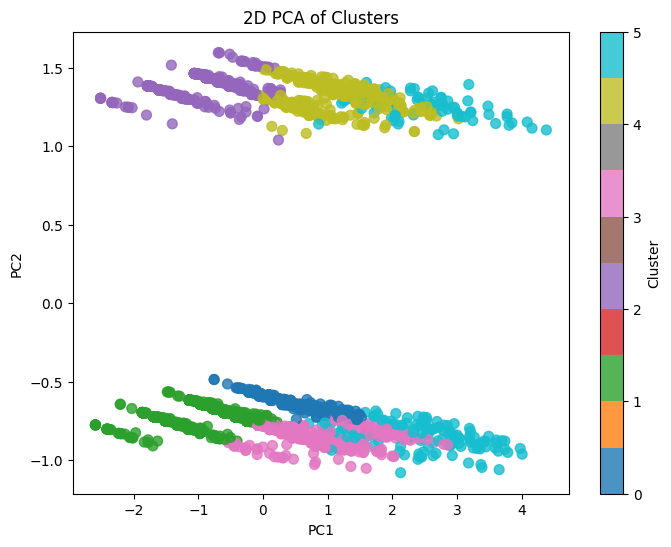

In [15]:
# 2d plot
plt.figure(figsize=(8,6))
sc = plt.scatter(
    X_pca_2d[:,0],
    X_pca_2d[:,1],
    c=cluster_df['cluster_labels'],
    cmap='tab10',
    s=50,
    alpha=0.8
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA of Clusters')
plt.colorbar(sc, label='Cluster')
plt.show()


## Interpreting the Clusters

<Axes: >

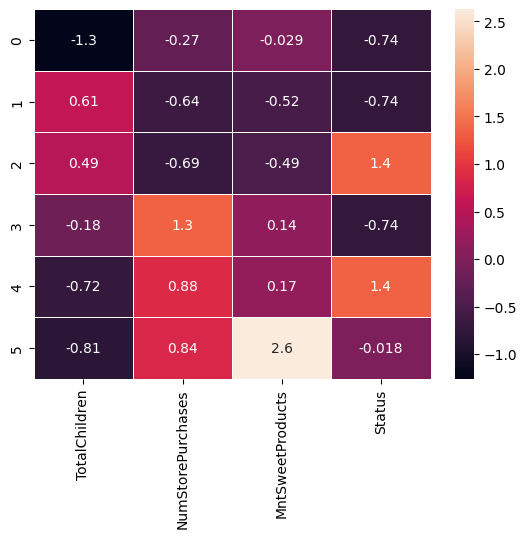

In [16]:
sns.heatmap(pd.DataFrame(kmeans.cluster_centers_, columns = df_scaled.columns), annot = True, linewidth = 0.5)

By clustering customers based on their buying behavior and demographics, we can target our new pastry section more effectively:

* **Cluster 5:**

  * Very high spending on sweet products (cakes, doughnuts, pastries)
  * Few children, mostly singles or living alone
  * **Action:** Primary target for promotions and loyalty rewards; focus on personal indulgence or *treat yourself* campaigns

* **Cluster 3:**

  * High overall store purchases, moderate sweet spending
  * Slightly below-average children, mostly couples
  * **Action:** Promote pastries as part of the in-store experience or in combo deals for shared/family consumption

* **Cluster 4:**

  * Above-average store purchases, moderate sweet spending
  * Few children, mostly singles or living alone
  * **Action:** Target with premium or limited-edition pastries emphasizing quality and exclusivity

* **Cluster 2:**

  * Below-average purchases and sweet spending, despite higher engagement in other aspects
  * Some children, mostly singles or living alone
  * **Action:** Use awareness campaigns highlighting premium or artisanal products to encourage trial

* **Clusters 0 & 1:**

  * Low purchases and low sweet product spending
  * Mix of family situations
  * **Action:** Focus on broad promotions or in-store tastings rather than direct ad campaigns

**Key Takeaway:** Marketing efforts should focus on **Clusters 5, 3, and 4**, using personalized strategies based on buying behavior and family/living situation, while minimizing spend on low-engagement clusters.